# Toy Model
## 2nd Version, trying to implement fitting algorithm

#ToDo:
- implement easier way to run parameter scans, or perhaps even simple fitting algorithm

# initialisation:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
# ExtractEnvFor:
import scipy.interpolate as intrp
import matplotlib as mpl
import time
import pandas
# Fitting
from lmfit import minimize, Parameters, Parameter, report_fit

# Interpolation and setting up EnvForcing

In [2]:
# functions adapted from PhytoSFDM Model by Esteban Acevedo-Trejos
def firstderivspl(Forcing, time, k=3, s=None):
    """
    Method to calculate the first derivative of an interpolated spline.

    Parameters
    ----------
    time: in days
    kind: the type of interpolation either linear, cubic, spline or
           piecewise polynomial
    k: Degree of the smoothing spline
    s: Positive smoothing factor used to choose the number of knots

    Returns
    -------
    The first derivative of the temporally interpolated environmental forcing spline.
    """
    outForcing = Forcing  # spatialave(Forcing)
    tmonth = np.linspace(0., 365., 13) #HERE deprecation warning due to 13. <- float, should be int
    newt = np.mod(time, 365.)
    outintp = intrp.UnivariateSpline(tmonth, outForcing, k=k, s=s)
    return outintp.derivative()(newt)

def dailyinterp(Forcing, time, kind='spline', k=3, s=None):
    """
    Method to interpolate from monthly to daily environmental data.

    Parameters
    -----
    time: in days
    kind: the type of interpolation either linear, cubic, spline or piecewise polynomial
    k: Degree of the smoothing spline
    s: Positive smoothing factor used to choose the number of knots

    Returns
    -------
    The temporally interpolated environmental forcing.
    """
    outForcing = Forcing  # spatialave(Forcing)

    tmonth = np.linspace(0., 12., 13) #HERE again, deprecation warning
    newt = np.mod(time, 365.) * 12. / 365.
    if kind == 'spline':
        outintp = intrp.UnivariateSpline(tmonth, outForcing, k=k, s=s)
        return outintp(newt)
    elif kind == 'PWPoly':
        outintp = intrp.PchipInterpolator(tmonth, outForcing)
        return outintp(newt)
    else:
        outintp = intrp.interp1d(tmonth, outForcing, kind=kind)
        return outintp(newt)

In [3]:
# parameters for interpolation
kmld = 3
smld = 0
kindmld = "spline"
kn0x = 5
sn0x = None
kindn0x = "spline"
kpar = 5
spar = None
kindpar = "spline"
ksst = 5
ssst = None
kindsst = "spline"
ksi0x = 5
ssi0x = None
kindsi0x = "spline"

In [4]:
# read environmental forcings
MLDfile = pandas.read_csv('CARIACO_forcing01/MLD')
MLD = list(MLDfile['press'])
MLD.append(MLDfile['press'][0])

NOXfile = pandas.read_csv('CARIACO_forcing01/N0')
NOX = list(NOXfile['as.numeric(NO3_NO2)'])
NOX.append(NOXfile['as.numeric(NO3_NO2)'][0])

SiOXfile = pandas.read_csv('CARIACO_forcing01/Si0')
SiOX = list(SiOXfile['as.numeric(Silicate)'])
SiOX.append(SiOXfile['as.numeric(Silicate)'][0])

SSTfile = pandas.read_csv('CARIACO_forcing01/SST')
SST = list(SSTfile['temp'])
SST.append(SSTfile['temp'][0])

PARfile = pandas.read_csv('CARIACO_forcing01/PAR')
PAR = list(PARfile['value'])
PAR.append(PARfile['value'][0])

In [5]:
# make all plots larger and more visible on dark background:
plt.rcParams['figure.figsize'] = [7, 6]
plt.rc_context({'axes.edgecolor':'black', 'xtick.color':'black', 'ytick.color':'black', 'figure.facecolor':'white'})

plt.rcParams['figure.dpi']= 300


# Actual Model

In [6]:
def simpleNPZD(x, t, paras):
    N = x[0] # Nitrate
    Si = x[1] # Silicate
    Z = x[2] # Zooplankton
    D = x[3] # Detritus
    P = x[4] # Phytoplankton
    y = np.zeros(len(x)) #initalize vector of derivatives
    
    # Interpolations of Forcings
    int_MLD = dailyinterp(MLD, t, kind=kindmld, k=kmld, s=smld)
    int_NOX = dailyinterp(NOX, t, kind=kindn0x, k=kn0x, s=sn0x)
    if int_NOX < 0 : int_NOX = 0 #do not allow negative Nitrate values
    int_SIOX = dailyinterp(SiOX, t, kind=kindsi0x, k=ksi0x, s=ssi0x)
    int_PAR = dailyinterp(PAR, t, kind=kindpar, k=kpar, s=spar)
    int_SST = dailyinterp(SST, t, kind=kindsst, k=ksst, s=ssst)
    
    # Derivatives of Forcings
    deriv_MLD = firstderivspl(MLD, t, k=kmld, s=smld)
    
    ####################!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    _kappa = paras['kappa'].value
    _kw = paras['kw'].value
    _OptI = paras['OptI'].value
    
    _deltaD_N = paras['deltaD_N'].value
    _deltaD_Si = paras['deltaD_Si'].value
    
    _U_N = paras['U_N'].value
    _U_Si = paras['U_Si'].value
    
    _v = paras['v'].value
    
    _muP = paras['muP'].value
    _moP = paras['moP'].value
    _Kp = paras['Kp'].value
    
    _ratioSi = paras['ratioSi'].value
    
    _gr_p = paras['gr_p'].value
    _muZ = paras['muZ'].value
    _moZ = paras['moZ'].value
    _deltaZ = paras['deltaZ'].value
    #####################!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    
    ## Non-Phytoplankton related processes
    # Mixing Processes
    DiffusiveMixing = (_kappa + max(deriv_MLD, 0)) / int_MLD # i.e. there is constant mixing & increased loss with MLD shallowing 
    ActiveMixing = deriv_MLD / int_MLD # i.e. concentration varies with the MLD depth
    
    # Zooplankton
    Ped = P * _gr_p   # Edible Phytoplankton
    ZooMortality = _moZ * Z ** 2 # Quadratic loss term for closure
    ZooMixing = Z * ActiveMixing # Zooplankton actively stay within the MLD
    
    # Remineralisation
    NRemineralization = _deltaD_N * D
    SiRemineralization = _deltaD_Si * D
    
    # Detritus
    DetritusMixing = D * DiffusiveMixing
    
    # Nutrient Mixing
    NMixing = DiffusiveMixing * (int_NOX - N)
    SiMixing = DiffusiveMixing * (int_SIOX - Si)
    
    y[0] = NRemineralization + NMixing   # Nitrate upwelling and remineralisation
    y[1] = SiRemineralization + SiMixing # Silicate upwelling and remineralisation
    y[2] = - ZooMortality - ZooMixing    # Zooplankton losses due to mortality and mixing
    y[3] = ZooMortality - NRemineralization - SiRemineralization - DetritusMixing 
    # Detriuts gains and losses (only input is Zooplankton mortality)

    
    ## Phytoplankton related processes
    # Nutrient uptake
    N_Uptake = N / (N + _U_N)       # Michaelis Menten - uptake of Nitrate
    
    Si_Uptake = Si / (Si + _U_Si)   # Michaelis Menten - uptake of Silicate

    # Light and Temperature 
    LightHarvesting = 1. / (_kw * int_MLD) * \
                (-np.exp(1. - int_PAR / _OptI) - \
                (-np.exp((1. - (int_PAR * np.exp(-_kw * int_MLD)) / _OptI))))
                          
    TemperatureDepGrowth = np.exp(0.063 * int_SST)
    
    # Phytoplankton Growth
    Gains = _muP * min(N_Uptake, Si_Uptake) * LightHarvesting * TemperatureDepGrowth
    
    # Phytoplankton Losses
    Grazing = _muZ * Z  / (Ped + _Kp)     # Zooplankton grazing as hyperbolic function
    Sinking = _v / int_MLD                # Phytoplankton sinking as a function of MLD and sinking rate
    OtherPMortalities = _moP              # Linear Phytoplankton mortality
    Losses = Grazing + Sinking + OtherPMortalities + DiffusiveMixing
                          
    # Zooplankton Growth & Grazing
    ZooGrowth = _deltaZ * Grazing * P
    UnassimilatedProduction = (1. - _deltaZ) * Grazing * P

    
    y[0] = y[0] - P * Gains # Nitrate drawdown
    y[1] = y[1] - P * _ratioSi * Gains # Silicate drawdown
                          
    y[2] = y[2] + ZooGrowth #Zooplankton growth                   
    
    y[3] = y[3] + UnassimilatedProduction + P * OtherPMortalities # Detritus
                        
    y[4] = P * (Gains - Losses) #Phytoplankton growth
    
    return y

In [7]:
# initialize parameters:
N0 = np.mean(NOX)             # Initial Nitrate concentration (mmol*m^-3)
Si0 = np.mean(SiOX)           # Initial Silicate concentration (mmol*m^-3)
Z0 = 0.1                      # Initial Zooplankton concentration (mmol*m^-3) 
D0 = 0.01                      # Initial Detritus concentration (mmol*m^-3)
P0 = 0.01                      # Initial Phytoplankton concentration (mmol*m^-3)


initcond = np.concatenate(([N0], [Si0], [Z0], [D0], [P0]), 0)
timedays_model = np.arange(0., 5 * 365., 1.0)

In [8]:
# params
kappa = 0.1                # Diffusive mixing across thermocline (m*d^-1)
kw = 0.1                   # Light attenuation constant (m^-1)
OptI = 30.                 # Optimum irradiance (einstein*m^-2*d^-1)

deltaD_N = 0.1             # Nitrate Mineralization rate (d^-1)
deltaD_Si = 0.1            # Silicate Mineralization rate (d^-1)

U_N = 5.01    #!          # Nitrate Half Saturation Constant
U_Si = 5.01   #!          # Silicate Half Saturation Constant                                   

v = 0.1      #!            # Sinking of Phytoplankton from Mixed Layer

muP = 1.1                  # Phytoplankton max growth rate (d^-1)
moP = 0.1                  # Phytoplankton mortality rate (d^-1)
Kp = 0.1                   # Phytoplankton half-saturation constant for ZooGrazing (µM)

ratioSi = 1                # ration of N to Si in Phytoplankton

gr_p = 0.6                 # Portion of Phytoplankton being grazed by Zooplankton
muZ = 0.1                  # Zooplankton maximum grazing rate (d^-1)
moZ = 0.1                  # Zooplankton mortality (d^-1)
deltaZ = 0.31              # Zooplankton Grazing assimilation coefficient (-)

########'!!!!!!!!!!!!!!!!!!!!!!!!!'

# set parameters including bounds; you can also fix parameters (use vary=False)
params = Parameters()
params.add('kappa', value=kappa, vary=False)
params.add('kw', value=kw, vary=False)
params.add('OptI', value=OptI, vary=False)

params.add('deltaD_N', value=deltaD_N, vary=False)
params.add('deltaD_Si', value=deltaD_Si, vary=False)

params.add('U_N',  min=0.5, max=10., brute_step = 0.5)
params.add('U_Si',  min=0.5, max=10., brute_step = 0.5)

params.add('v', value=v, vary=False)

params.add('muP', min=0.1, max=3.,  brute_step = 0.1)
params.add('moP', value=moP, vary=False)
params.add('Kp', value=Kp, vary=False)

params.add('ratioSi', value=ratioSi, vary=False)

params.add('gr_p', value=gr_p, vary=False)
params.add('muZ', value=muZ, vary=False)
params.add('moZ', value=moZ, vary=False)
params.add('deltaZ', value=deltaZ, vary=False)

# for parameter to be fitted:
#params.add('k0', value=0.2, min=0.0001, max=2.)


# Integration

# Fit model to data

In [9]:
# read yearly data (for comparison to model) from Cariaco
ChlA = pandas.read_csv('../CARIACOModelingProject/Data/DataFiles_Processed/ChlA_bottle_yearly_surface.csv')

NO3NO2 = pandas.read_csv('../CARIACOModelingProject/Data/DataFiles_Processed/NO3NO2_bottle_yearly_surface.csv')

SiOH_UDO = pandas.read_csv('../CARIACOModelingProject/Data/DataFiles_Processed/SiOH_UDO_bottle_yearly_surface.csv')
SiOH_USF = pandas.read_csv('../CARIACOModelingProject/Data/DataFiles_Processed/SiOH_USF_bottle_yearly_surface.csv')

# Zooplankton:
ZooBM = pandas.read_csv('../CARIACOModelingProject/Data/DataFiles_Processed/ZooBM_All.csv')
# zooplankton biomass is in [mg/m^3 dry weight]
# for now, a 10% N content of the dry weight of all Zooplankton is assumed, 
# [Gorsky et al. 1988] "C and N composition of some northwestern Mediterranean zooplankton and micronekton species"
# to convert the values to µM  N  ::  1 mg N/m^3 = 0.071394 μM N 

## calculate monthly medians for simplified/more efficient model fitting

In [10]:
ChlA = ChlA.assign(month = pandas.to_datetime(ChlA['yday'], format='%j').dt.month)
NO3NO2 = NO3NO2.assign(month = pandas.to_datetime(NO3NO2['yday'], format='%j').dt.month)
SiOH_USF = SiOH_USF.assign(month = pandas.to_datetime(SiOH_USF['yday'], format='%j').dt.month)
ZooBM = ZooBM.assign(month = pandas.to_datetime(ZooBM['yday'], format='%j').dt.month)

ChlA_monthly_median = ChlA.groupby('month').median() 
NO3NO2_monthly_median = NO3NO2.groupby('month').median() 
SiOH_USF_monthly_median = SiOH_USF.groupby('month').median() 
ZooBM_monthly_median = ZooBM.groupby('month').median() 

       yday   ChlA
month             
1        11  1.065
2        40  1.190
3        69  1.050
4        98  0.380
5       129  0.205
6       159  0.155
7       189  0.235
8       221  0.160
9       253  0.165
10      281  0.140
11      313  0.130
12      341  0.200


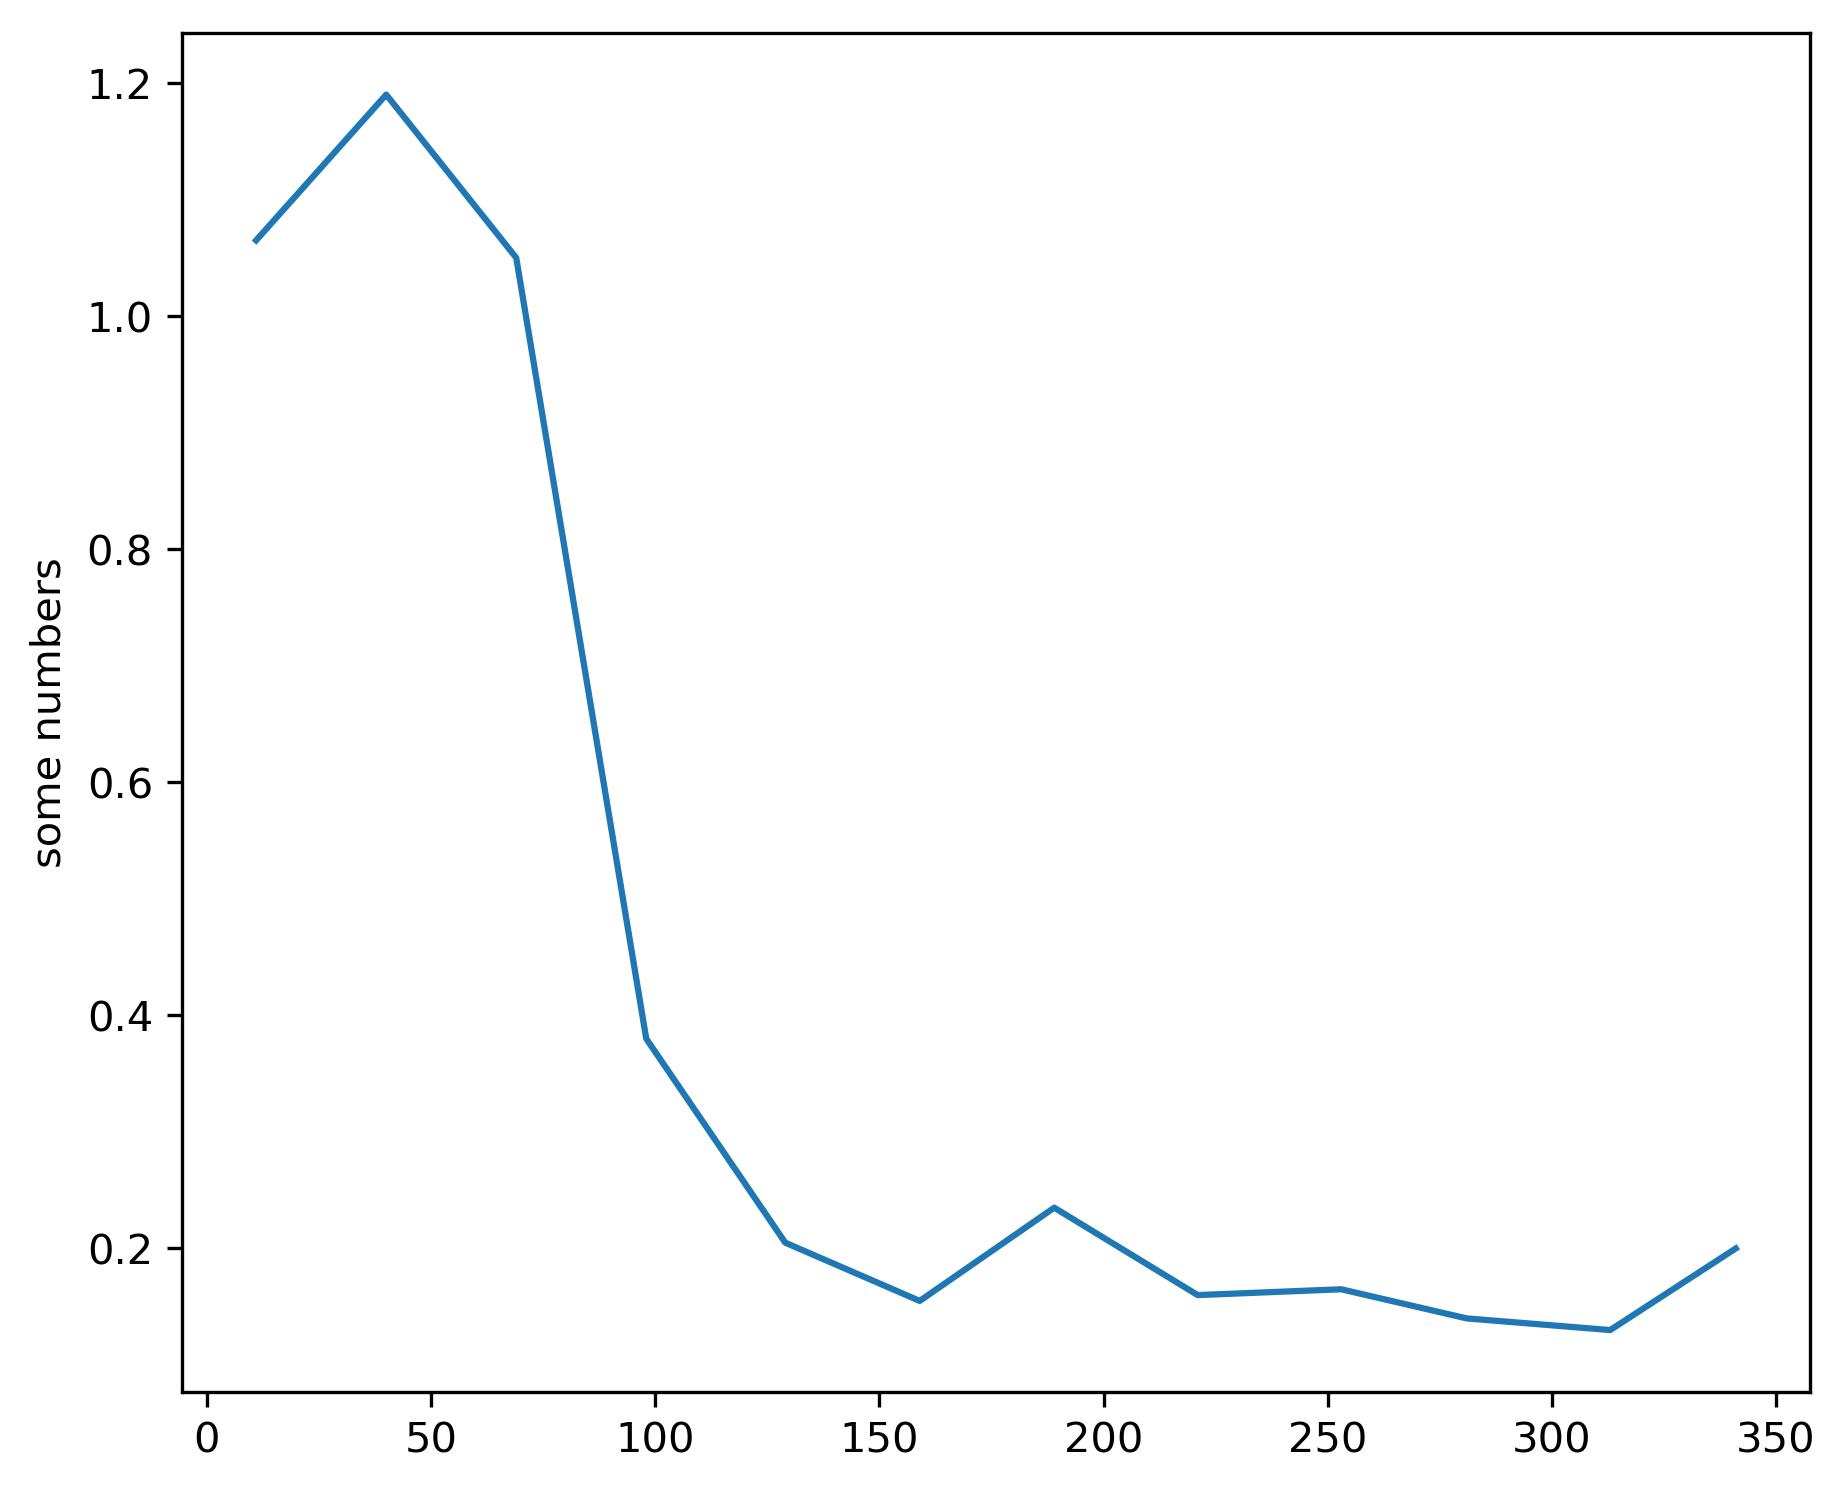

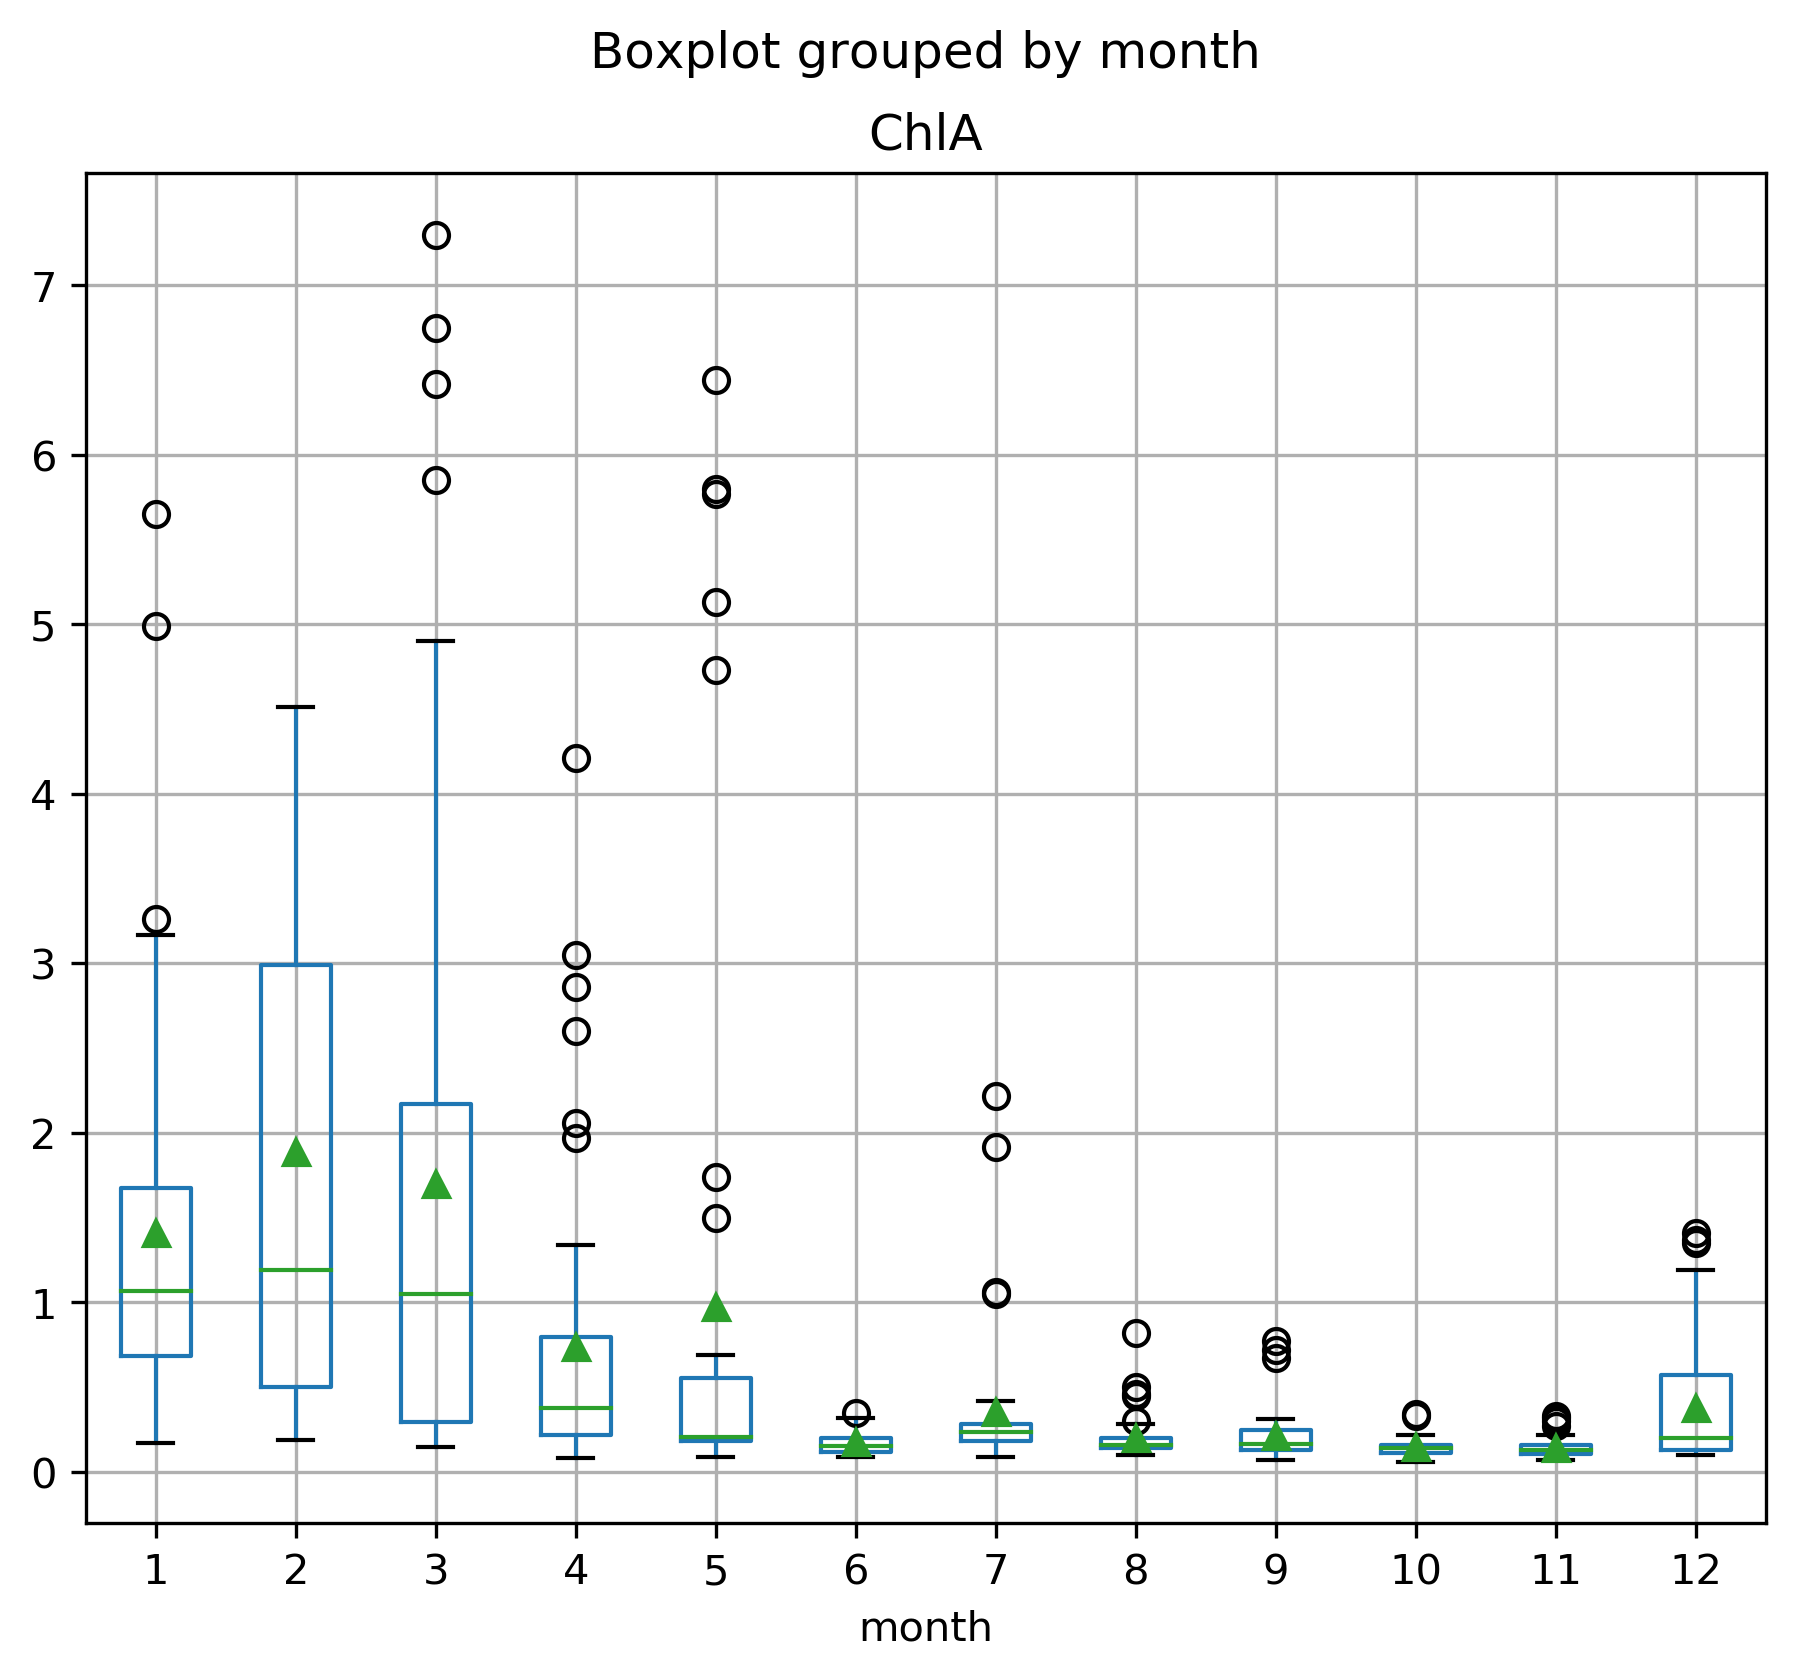

In [11]:
print(ChlA_monthly_median)
plt.plot(ChlA_monthly_median['yday'], ChlA_monthly_median['ChlA'])
plt.ylabel('some numbers')
plt.show()

#
 #int_NOX = dailyinterp(NOX, t, kind=kindn0x, k=kn0x, s=sn0x)
    
#ChlA_plot = pandas.DataFrame(data=ChlA['ChlA'], month=ChlA['month'] )
ChlA.boxplot(by='month', column='ChlA', showmeans=True)
#plt.boxplot( [ ChlA_plot.loc[i] for i in ChlA_plot.index ], vert=True )

# define how to calculate residual for fitting

In [12]:
def residual(paras):

    """
    compute the residual between actual data and fitted data
    """

    model = g(initcond, timedays_model, paras)
    
    # to implement fitting algorithm make sure to calculate residual only for the last year!
    
    # will have to 1. : simplify the data (i.e. median per month)
    # will have to put data into structure to calculate efficiently (i.e. pandas dataframe like df[1] = N, df[2] = Si, etc.)
    model_ly = model[1460:1825]

    # aggregate model output in the same way as validation data (monthly mean)
    # create month vector to add to model output dataframe for analysis
    oneyearmodel = pandas.DataFrame()
    oneyearmodel = oneyearmodel.assign(day=pandas.Series(np.linspace(1,365,365)))

    # combine two columns
    phyto_model = pandas.DataFrame({'data':model_ly[:,4],'month':pandas.to_datetime(oneyearmodel['day'], format='%j').dt.month})
    phyto_monthly_median = phyto_model.groupby('month').median() 
    phyto_resid = (phyto_monthly_median['data'].values - ChlA_monthly_median['ChlA'].values*0.1)

    nitrate_model = pandas.DataFrame({'data':model_ly[:,0],'month':pandas.to_datetime(oneyearmodel['day'], format='%j').dt.month})
    nitrate_monthly_median = nitrate_model.groupby('month').median() 
    nitrate_resid = (nitrate_monthly_median['data'].values - NO3NO2_monthly_median['NO3NO2'].values*0.1)

    silicate_model = pandas.DataFrame({'data':model_ly[:,1],'month':pandas.to_datetime(oneyearmodel['day'], format='%j').dt.month})
    silicate_monthly_median = silicate_model.groupby('month').median() 
    silicate_resid = (silicate_monthly_median['data'].values - SiOH_USF_monthly_median['SiOH'].values*0.1)

    zoo_model = pandas.DataFrame({'data':model_ly[:,3],'month':pandas.to_datetime(oneyearmodel['day'], format='%j').dt.month})
    zoo_monthly_median = zoo_model.groupby('month').median() 
    zoo_resid = (zoo_monthly_median['data'].values - ZooBM_monthly_median['ZooBM'].values*0.1)

    ss = np.concatenate((phyto_resid, nitrate_resid, silicate_resid, zoo_resid))
    return phyto_resid

## wrap Model function for simplicity

In [13]:
def g(x0, t, paras):
    """
    Solution to the ODE x'(t) = f(t,x,k) with initial condition x(0) = x0
    """
    x = odeint(simpleNPZD, x0, t, args=(paras,))
    return x

# do the fitting

In [14]:
# fit model
result = minimize(residual, params, args=(), method='differential_evolution')  # leastsq nelder
# check results of the fit
outarray = g(initcond, timedays_model, result.params)
print(result.aic)

-81.88951877375598


In [15]:
report_fit(result)
print(result.residual)

[[Fit Statistics]]
    # fitting method   = differential_evolution
    # function evals   = 1319
    # data points      = 12
    # variables        = 3
    chi-square         = 0.00791322
    reduced chi-square = 8.7925e-04
    Akaike info crit   = -81.8895188
    Bayesian info crit = -80.4347988
[[Variables]]
    kappa:      0.1 (fixed)
    kw:         0.1 (fixed)
    OptI:       30 (fixed)
    deltaD_N:   0.1 (fixed)
    deltaD_Si:  0.1 (fixed)
    U_N:        2.12123130 (init = 0.5)
    U_Si:       9.91546633 (init = 0.5)
    v:          0.1 (fixed)
    muP:        0.56326510 (init = 0.1)
    moP:        0.1 (fixed)
    Kp:         0.1 (fixed)
    ratioSi:    1 (fixed)
    gr_p:       0.6 (fixed)
    muZ:        0.1 (fixed)
    moZ:        0.1 (fixed)
    deltaZ:     0.31 (fixed)
[-3.44347163e-02 -1.06884992e-02 -4.60578473e-02 -2.12345782e-02
 -1.04720804e-02 -2.68827645e-03 -5.85809258e-05  3.06582224e-02
  5.22297943e-02  5.00371734e-03 -1.34257395e-03  1.51454908e-02]


In [16]:
timedays = timedays_model[1:366]
#truncate outarraySiNO to last year of 5:
outarray_ly = outarray[1460:1825]

# plot results

In [17]:
# color vectors
colors = ['#00C90D', '#01939A', 'black', 'grey', '#E2680B']
alphas = [1., 0.8, 0.6, 0.4]
lws = [1, 2.5, 4, 5.5]

# artist for legends
FullArtist = plt.Line2D((0, 1), (0, 0), c=colors[4], alpha=alphas[1], lw=lws[0])

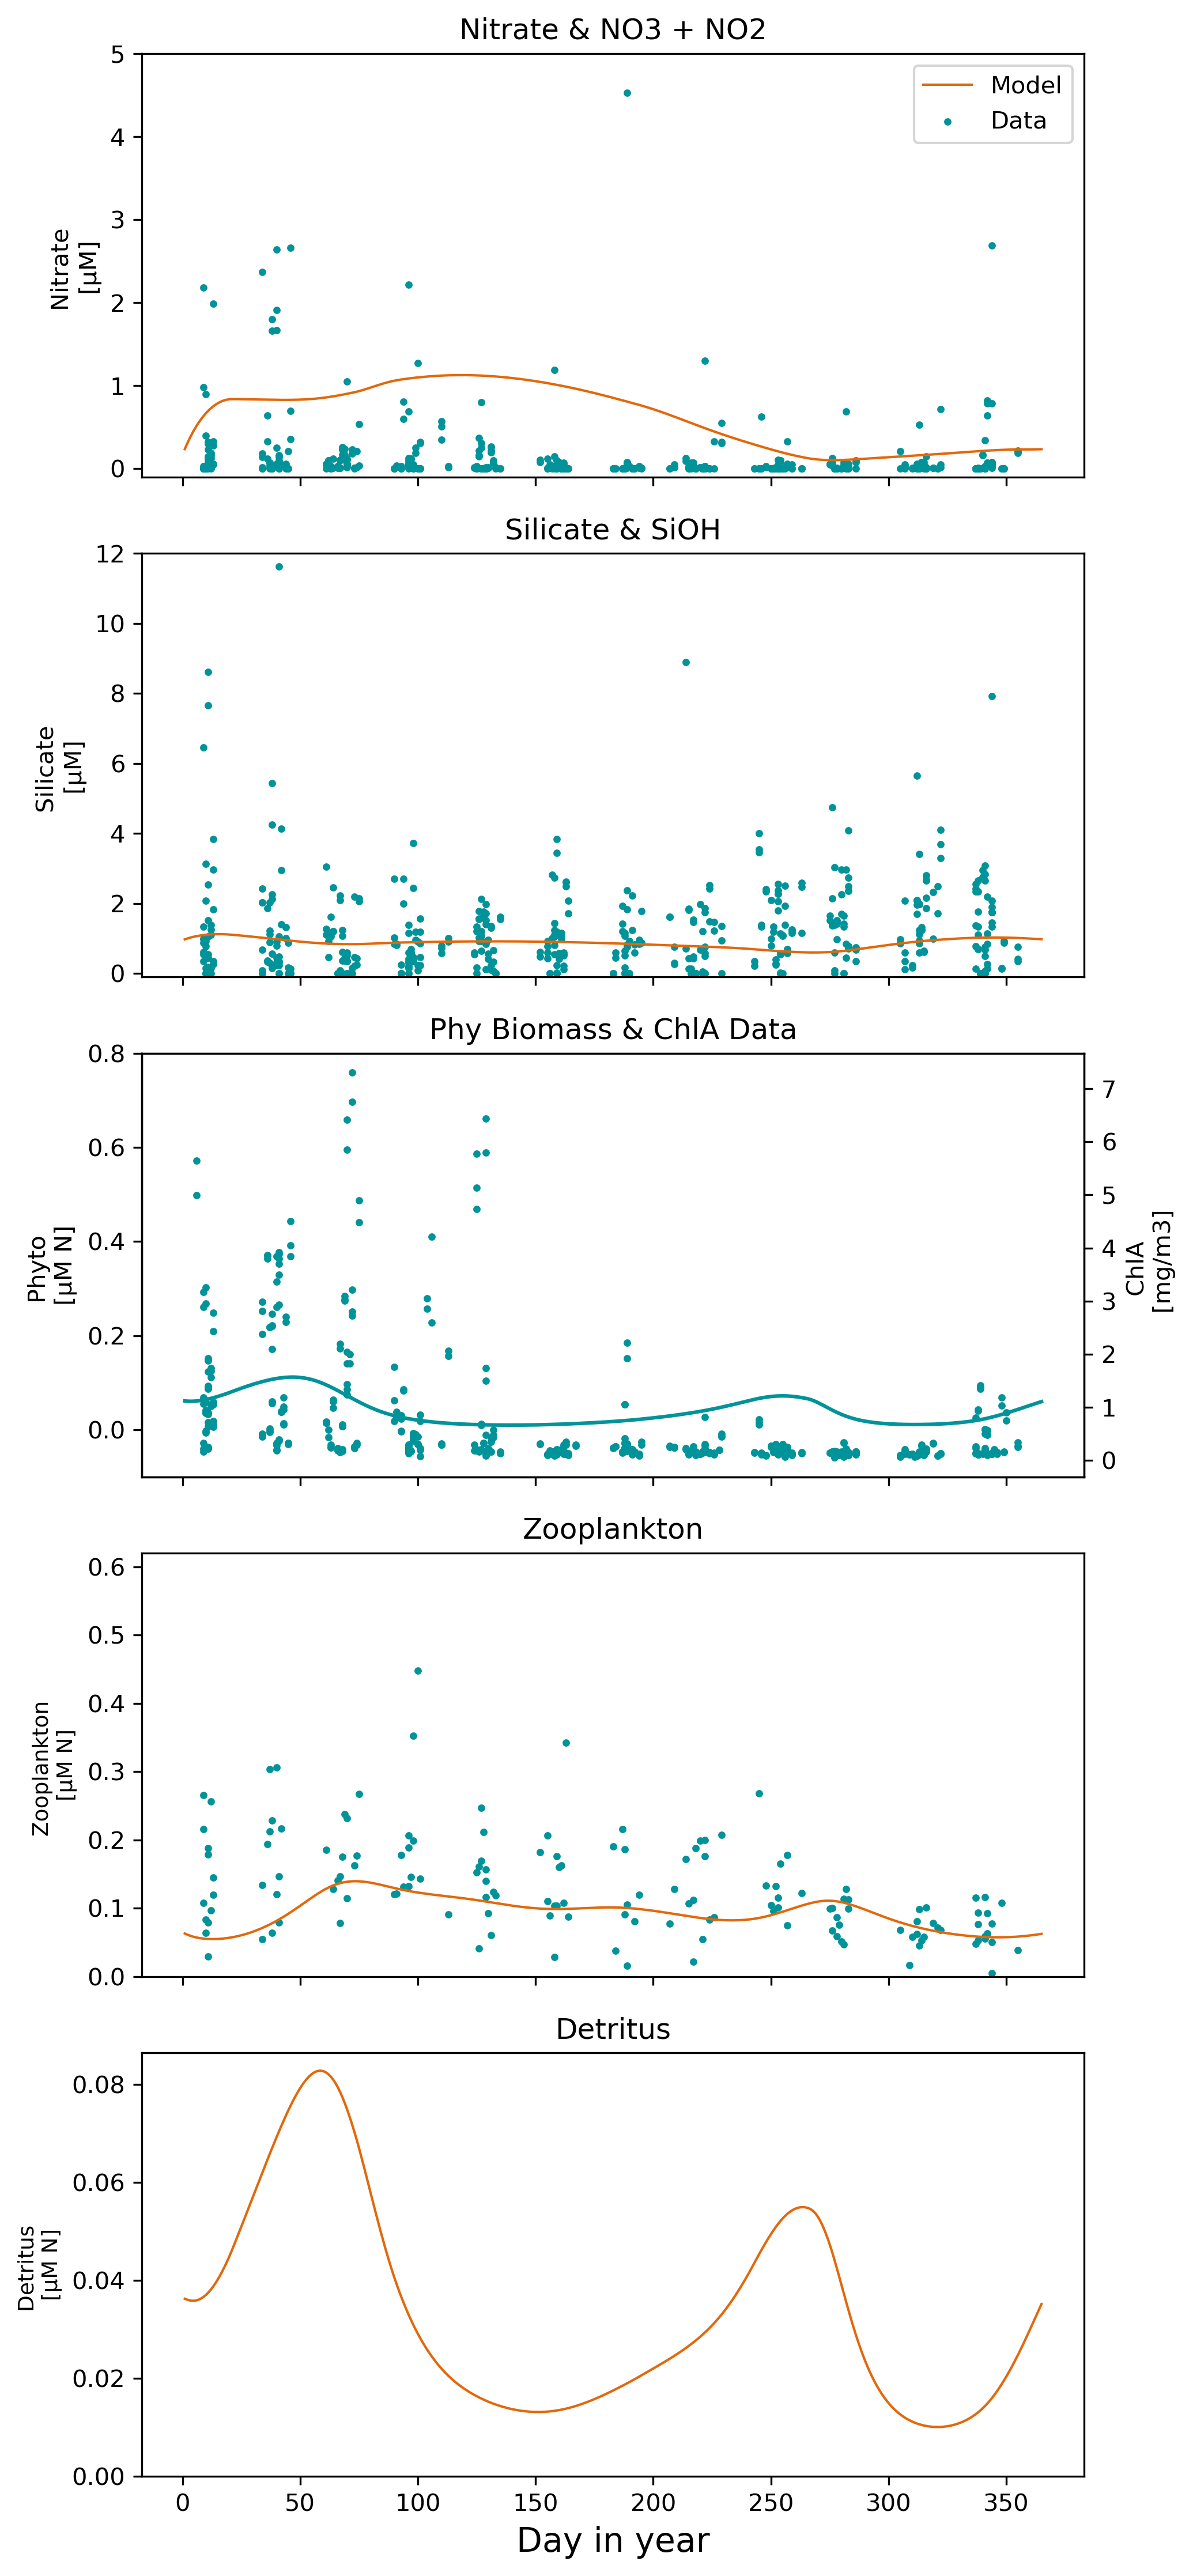

In [18]:
# Figure 1
f1, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, sharex='col', sharey='row')
# N
ax1.plot(timedays, outarray_ly[:, 0], c=colors[4], lw=lws[0], alpha=alphas[0], label='Model')
ax1.set_ylabel('Nitrate \n' '[µM]', multialignment='center', fontsize=10)
ax1.set_ylim(-0.1, 5)

# N Data
ax1.scatter(NO3NO2['yday'].values, NO3NO2['NO3NO2'].values, c=colors[1],s=4.3, label='Data')
ax1.set_title('Nitrate & NO3 + NO2')
ax1.legend(loc=1)

# Si
ax2.plot(timedays, outarray_ly[:, 1], c=colors[4], lw=lws[0], alpha=alphas[0])
ax2.set_ylabel('Silicate \n' '[µM]', multialignment='center', fontsize=10)
ax2.set_ylim(-0.1, 12)
# Si Data
ax2.scatter(SiOH_USF['yday'].values, SiOH_USF['SiOH'].values, c=colors[1],s=4.3)
ax2.set_title('Silicate & SiOH')

#Phyto
ax3.plot(timedays, outarray_ly[:, 4], c=colors[1])
ax3.set_ylabel('Phyto \n' '[µM N]', multialignment='center', fontsize=10)
ax3.set_ylim(-0.1, 0.8)
# Phyto Data
ax3_tx = ax3.twinx()
ax3_tx.scatter(ChlA['yday'].values, ChlA['ChlA'].values, c=colors[1],s=4.3)
ax3_tx.set_ylabel('ChlA \n [mg/m3]')

ax3.set_title('Phy Biomass & ChlA Data')

# Z
ax4.plot(timedays, outarray_ly[:, 2], c=colors[4], lw=lws[0], alpha=alphas[0])
ax4.set_ylabel('Zooplankton \n' '[µM N]', multialignment='center', fontsize=9)
ax4.tick_params('y', labelsize=10)

ax4.scatter(ZooBM['yday'].values, ZooBM['ZooBM'].values*0.1*0.071394, c=colors[1],s=4.3)
# 10% N of dry weight assumed, converted to µM

ax4.set_title('Zooplankton')
ax4.set_ylim(0, 0.62)

# D
ax5.plot(timedays, outarray_ly[:, 3], c=colors[4], lw=lws[0], alpha=alphas[0])
ax5.set_ylabel('Detritus \n' '[µM N]', multialignment='center', fontsize=9)

ax5.set_title('Detritus')
ax5.set_ylim(bottom=0)

ax5.set_xlabel('Day in year', fontsize=14)
# Legend


#plt.subplots_adjust(hspace=0.01)
f1.set_figheight(15)
plt.tight_layout()
plt.show()